In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/최애림/cakd7/m9_딥러닝/3차 프로젝트/5팀(윤정준, 최애림, 진청아, 이정현a)/코드
# %cd ./drive/MyDrive/cakd7/3차프로젝트_dl_1025_1128/5팀\(윤정준,\ 최애림,\ 진청아,\ 이정현a\)/코드

/content/drive/.shortcut-targets-by-id/1niQkF2oFYkuV2aahMfHbpa3kXs5yrcAd/5팀(윤정준, 최애림, 진청아, 이정현a)/코드


# 종양 여부에 따른 이미지 패치화

## 필요 라이브러리 임포트

In [ ]:
# C 라이브러리, PYTHON bindings 라이브러리 설치
!apt-get install openslide-tools
!apt-get install python3-openslide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 5 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (339 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [ ]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import numpy as np
# from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

!pip install ipython-autotime

%load_ext autotime
%tensorflow_version 2.x
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
time: 2.32 s (started: 2022-11-30 07:50:07 +00:00)


### 데이터 불러올 경로 지정

In [ ]:
# 경로 지정

slide_dirs = './imgs_tiff/2. train_imgs_tiff'
mask_dirs = './imgs_tiff/2. train_masks_tiff'


slide_paths = [slide_dirs + '/' + slide_img for slide_img in os.listdir(slide_dirs)]
mask_paths = [mask_dirs + '/' + mask_img for mask_img in os.listdir(slide_dirs)]
print(slide_paths[:2])
print(mask_paths[:2])

['./imgs_tiff/2. train_imgs_tiff/BC_01_0015.tiff', './imgs_tiff/2. train_imgs_tiff/BC_01_0397.tiff']
['./imgs_tiff/2. train_masks_tiff/BC_01_0015.tiff', './imgs_tiff/2. train_masks_tiff/BC_01_0397.tiff']
time: 12.9 ms (started: 2022-11-25 11:15:39 +00:00)


# 모델링

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

base_model = tf.keras.applications.InceptionV3(input_shape=[96, 96, 3], include_top=False, weights='+imagenet')
base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

## 저장한 배열이미지 데이터 불러오기

In [ ]:
# 오버랩된 패치들 
dataset_patch_tumor = np.load('./array/1130_all_tumor_array_10.npy')
dataset_patch_normal = np.load('./array/1130_all_normal_array_10.npy')
dataset_patches_all = np.vstack((dataset_patch_tumor, dataset_patch_normal))
print(dataset_patch_tumor.shape)
print(dataset_patch_normal.shape)
print(dataset_patches_all.shape)

dataset_label_tumor = np.ones(dataset_patch_tumor.shape[0])
dataset_label_normal = np.zeros(dataset_patch_normal.shape[0])
dataset_label = np.hstack((dataset_label_tumor, dataset_label_normal))
print(dataset_label)

(192077, 32, 32, 3)
(47870, 32, 32, 3)
(239947, 32, 32, 3)
[1. 1. 1. ... 0. 0. 0.]
time: 3.02 s (started: 2022-11-30 07:51:06 +00:00)


In [ ]:
del dataset_patch_tumor, dataset_patch_normal, dataset_label_tumor, dataset_label_normal

time: 781 µs (started: 2022-11-30 07:51:19 +00:00)


In [ ]:
dataset_patches_all.shape

(239947, 32, 32, 3)

time: 3.33 ms (started: 2022-11-30 07:51:22 +00:00)


## 종양, 비종양 비율 맞추지 않고 진행

### 종양 여부에 따라 데이터 나누기

In [ ]:
pd.Series(dataset_label).value_counts()

1.0    192077
0.0     47870
dtype: int64

time: 15.1 ms (started: 2022-11-30 07:51:25 +00:00)


In [ ]:
patches_with_tumor = np.array([dataset_patches_all[ind, :, :] for ind in range(len(dataset_label)) if dataset_label[ind] == 1])
patches_without_tumor = np.array([dataset_patches_all[ind, :, :] for ind in range(len(dataset_label)) if dataset_label[ind] == 0])

time: 471 ms (started: 2022-11-30 07:51:33 +00:00)


In [ ]:
patches_with_tumor.shape, patches_without_tumor.shape

((192077, 32, 32, 3), (47870, 32, 32, 3))

time: 3.99 ms (started: 2022-11-30 07:51:37 +00:00)


### 패치 개수 맞춰주기

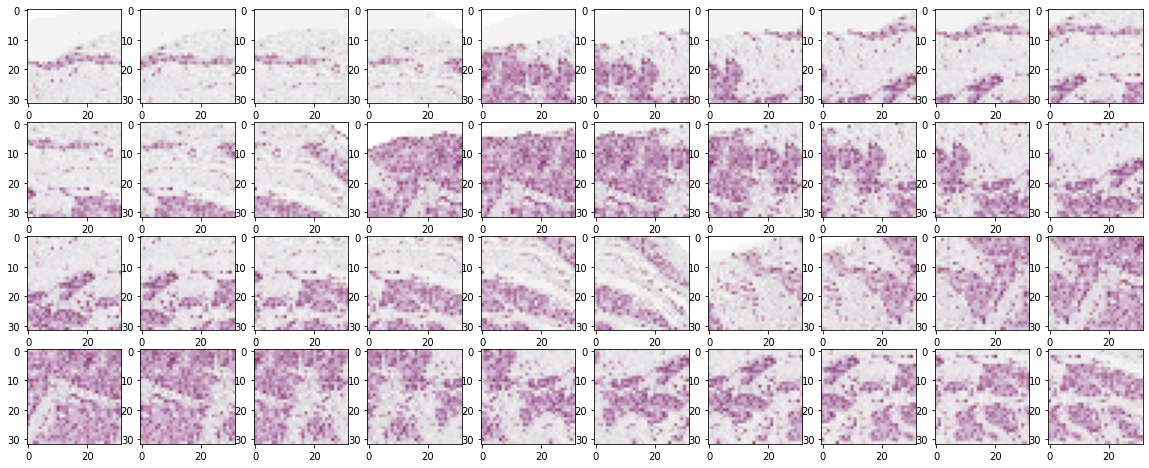

time: 3.94 s (started: 2022-11-30 07:51:44 +00:00)


In [ ]:
# 종양 부분  
plt.figure(figsize = (20,8))
for i in range(40):
  ax = plt.subplot(4, 10, i + 1)
  plt.imshow(patches_with_tumor[i])

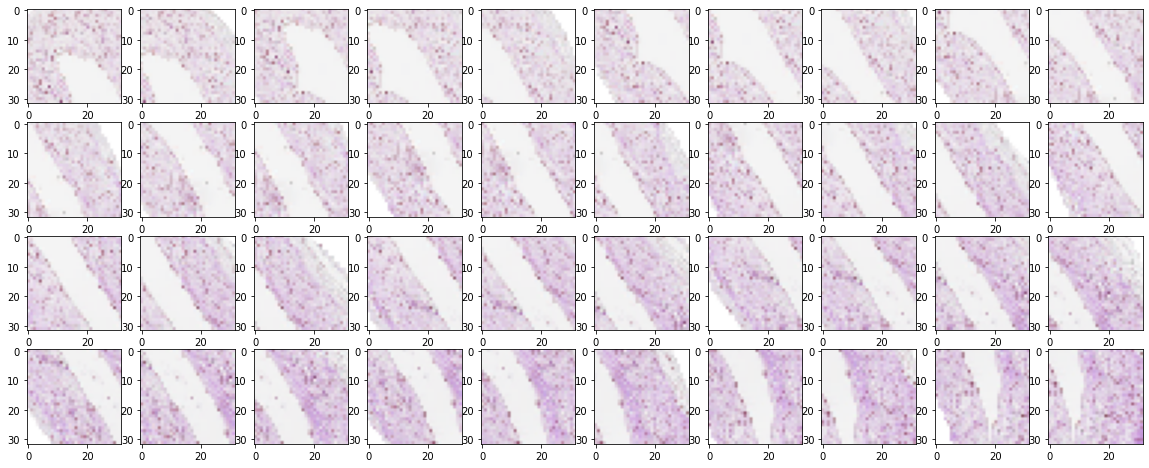

time: 3.65 s (started: 2022-11-30 07:51:51 +00:00)


In [ ]:
# 비종양 부분
plt.figure(figsize = (20,8))
for i in range(40):
  ax = plt.subplot(4, 10, i + 1)
  plt.imshow(patches_without_tumor[i])

### 훈련 및 테스트용 데이터 분리

In [ ]:
# 훈련/테스트용 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(dataset_patches_all, 
                                                  dataset_label, 
                                                  test_size=0.25, 
                                                  random_state=43)

time: 190 ms (started: 2022-11-30 07:52:01 +00:00)


In [ ]:
del dataset_patches_all, dataset_label

time: 611 µs (started: 2022-11-30 07:52:04 +00:00)


In [ ]:
# 정규화: X_train

for i in range(0, X_train.shape[0]//10000 + 1):
  X_train[i*10000:(i+1)*10000] = (X_train[i*10000:(i+1)*10000]/ 255.) * 2.0 - 1
  if i == X_train.shape[0]//10000:
    X_train[i*10000:] = (X_train[i*10000:]/ 255.) * 2.0 - 1

time: 2.1 s (started: 2022-11-30 07:52:06 +00:00)


In [ ]:
# 정규화: X_val

for i in range(0, X_val.shape[0]//10000 + 1):
  X_val[i*10000:(i+1)*10000] = (X_val[i*10000:(i+1)*10000]/ 255.) * 2.0 - 1
  if i == X_val.shape[0]//10000:
    X_val[i*10000:] = (X_val[i*10000:]/ 255.) * 2.0 - 1

time: 779 ms (started: 2022-11-30 07:52:10 +00:00)


### 모델링

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
import keras

# Freeze all weights
base_model.trainable = False 

# Add input transpose conv layer
input_layer = tf.keras.layers.InputLayer(
    input_shape=[32, 32, 3])
input_tranConv = tf.keras.layers.Conv2DTranspose(3, [3, 3], 
                                                 strides=3,
                                                 padding='same',
                                                 use_bias=False)

# Add last layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Build a new model reusing the pretrained base
model = tf.keras.Sequential([
                              input_layer,
                              input_tranConv,                           
                              base_model,
                              global_average_layer,
                              prediction_layer
])

# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20, 
                                                  restore_best_weights = True, 
                                                  monitor = 'val_loss')
optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_m])

time: 965 ms (started: 2022-11-30 07:56:59 +00:00)


In [ ]:
# Check the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 96, 96, 3)        81        
 nspose)                                                         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,914
Trainable params: 2,130
Non-trainable params: 21,802,784
_________________________________________________________________
time: 116 ms (started: 2022-11-30 07:52:

### 학습

In [ ]:
# 모델 저장을 위한 경로 지정
drive_root = './'
checkpoint_dir = os.path.join(drive_root, "Checkpoints", "InceptionV3-Freeze40-UnbalData")


# Checkpoints 폴더가 없으면 생성하기
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


# Checkpoints 폴더 내 best_params 모델 저장
checkpoint_path = os.path.join(checkpoint_dir, "1130_all_10픽셀_TumorNormal_best_model.hdf5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                          filepath = checkpoint_path, 
                                                          monitor = 'val_loss',  
                                                             ## val_loss로 모델의 best를 판단
                                                          verbose = 0, 
                                                          save_best_only = True,
                                                             ## True: monitor 되고 있는 값을 기준 베스트 모델만 저장
                                                             ## False: 모든 epoch마다 모델 저장
                                                          save_weights_only = False, 
                                                             ## True: 모델 weights만 저장
                                                             ## false:모델 레이어 및 weights 모두 저장
                                                          mode = 'auto')
                                                             ## max: 보통 moniter값이 val_acc인 경우 사용
                                                             ## min: 보통 moniter값이 val_loss인 경우 사용
                                                             ## auto: 모델이 알아서 min, max를 판단 

Checkpoints directory is ./Checkpoints/InceptionV3-Freeze40-UnbalData
Checkpoints folder already exists
time: 8.38 ms (started: 2022-11-30 07:57:02 +00:00)


In [ ]:
# Train the first and last layer first
EPOCH = 200
BATCH_SIZE = 512
y_train = np.array(y_train)
y_val = np.array(y_val)
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = EPOCH, 
                    # callbacks = [early_stopping_cb], 
                    callbacks = [checkpoint_callback, early_stopping_cb],
                    batch_size = BATCH_SIZE)

Epoch 1/200
352/352 [==============================] - 159s 435ms/step - loss: 0.6014 - accuracy: 0.7887 - recall_m: 0.9786 - precision_m: 0.8015 - f1_m: 0.8789 - val_loss: 0.6769 - val_accuracy: 0.7997 - val_recall_m: 0.9991 - val_precision_m: 0.8001 - val_f1_m: 0.8884
Epoch 2/200
352/352 [==============================] - 156s 443ms/step - loss: 0.5190 - accuracy: 0.7955 - recall_m: 0.9896 - precision_m: 0.8015 - f1_m: 0.8855 - val_loss: 0.5402 - val_accuracy: 0.7995 - val_recall_m: 0.9986 - val_precision_m: 0.8001 - val_f1_m: 0.8883
Epoch 3/200
352/352 [==============================] - 155s 439ms/step - loss: 0.5319 - accuracy: 0.7948 - recall_m: 0.9887 - precision_m: 0.8013 - f1_m: 0.8850 - val_loss: 0.5666 - val_accuracy: 0.7033 - val_recall_m: 0.8371 - val_precision_m: 0.7968 - val_f1_m: 0.7559
Epoch 4/200
352/352 [==============================] - 156s 444ms/step - loss: 0.5335 - accuracy: 0.7965 - recall_m: 0.9917 - precision_m: 0.8013 - f1_m: 0.8862 - val_loss: 0.5277 - val_a